In [1]:
%config InlineBackend.rc = {"figure.dpi": 72, 'figure.figsize': (6.0, 4.0)}
%matplotlib inline

import ase
from abtem.reconstruct import RegularizedPtychographicOperator
from matplotlib import pyplot as plt

import abtem

# Ptychography with PIE

Ptychography describes a family of reconstruction algorithms which attempts to find a phase object $O(\vec{r})$ (representing the electrostatic potential) and a probe $P(\vec{r})$ from a collection of overlapping diffraction patterns. Given a some guess, the wave function describing the probe at a given position $\vec{r}_p$ is, in the weak phase approximation, given as

$$
    \psi(\vec{r}_p, \vec{r}) = O(\vec{r}) P(\vec{r}_p, \vec{r}) \quad ,
$$

thus the equivalent diffraction pattern is

$$
I(\vec{r}_p, \vec{k}) = \| \mathcal{F} \left[ O(\vec{r}) P(\vec{r}_p, \vec{r})\right] \|^2 \quad .
$$

Given a collection of measured diffraction patterns $I_{measured}(\vec{r}_p, \vec{r})$, our goal is to minimize the sum of squared errors

$$
    \mathrm{SSE} = \sum_{\vec{r}_p, \vec{k}} = (I_{measured}(\vec{r}_p, \vec{k}) - I(\vec{r}_p, \vec{k})) ^2 \ .
$$

The Ptychographic Iterative Engine (PIE) is an iterative technique which at each step transmits a guess of the probe to produce a guess of the resulting diffraction, the guess for that exitr wave, $\psi_j(\vec{r}_p, \vec{r})$, by replacing its reciprocal space amplitude with the square root of the measured diffraction pattern. This producedure is continued until convergence.

abTEM implements several different flavors of PIE:
* `RegularizedPtychographicOperator`: Used to reconstruct weak-phase objects.
* `SimultaneousPtychographicOperator`: Used to reconstruct the electrostatic phase and magnetic phase objects simultaneously. 
* `MixedStatePtychographicOperator`: Used to reconstruct weak-phase objects with partial coherence. 
* `MultislicePtychographicOperator`: Used to reconstruct _thick_ weak-phase objects. 

In this tutorial, we describe how to use regularized PIE{cite}`maiden_pie` with the `RegularizedPtychographicOperator`.

## 4D-STEM simulation of WS2

As a test system we will simulate WS2.

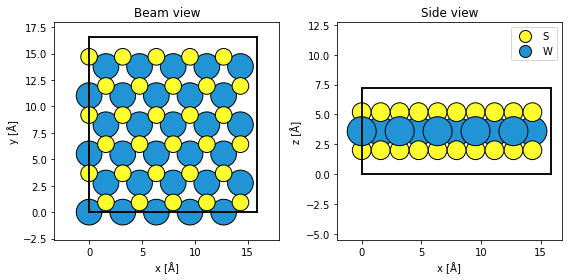

In [2]:
atoms = ase.build.mx2("WS2", vacuum=2)

atoms = abtem.orthogonalize_cell(atoms) * (5, 3, 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
abtem.show_atoms(atoms, ax=ax1, title="Beam view")
abtem.show_atoms(atoms, plane="xz", ax=ax2, title="Side view", legend=True)
fig.tight_layout()

We create the potential and a probe, the aberrations of the probe are deliberately exaggerated to demonstrate the capabilities of the ePIE algorithm.

[########################################] | 100% Completed | 1.57 ss
[########################################] | 100% Completed | 224.99 ms


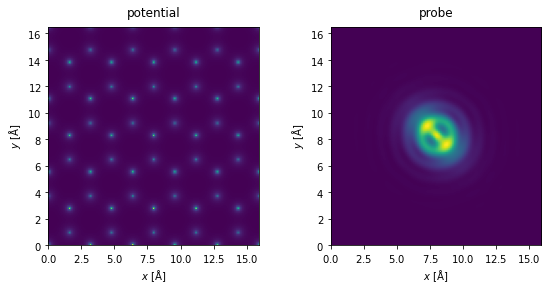

In [3]:
potential = abtem.Potential(
    atoms,
    sampling=0.05,
)

aberrations = {"C10": -130, "C12": 20, "phi12": 0.785, "C30": -2e4}

probe = abtem.Probe(semiangle_cutoff=20, energy=100e3, **aberrations)

probe.grid.match(potential)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
potential.show(ax=ax1, title="potential")
probe.show(ax=ax2, title="probe")
fig.tight_layout()

We run a 4D-STEM simulation over a periodic area of the sample (i.e. using fractional coordinates we scan the reciprocal of the number of repetitions of the potential, see our walkthrough for details). In contrast to when we simulate STEM-ADF images scanning at the Nyquist sampling rate has no particular significance, as the sampling of the reconstruction is determined by the maximum scattering angle of the diffraction patterns, however, to make a comparison we scan at the Nyquist sampling rate (the default).

In [4]:
scan = abtem.GridScan(
    start=(0, 0), end=(1 / 5, 1 / 3), fractional=True, potential=potential,
)

pixelated_detector = abtem.PixelatedDetector()

diffraction_patterns = probe.scan(potential, scan=scan, detectors=pixelated_detector)

diffraction_patterns.compute()

[########################################] | 100% Completed | 6.78 sms


We can crop the measurement to a match the maximum detected angle of specific detector, here we crop it to maximum scattering angle of $80 \ \mathrm{mrad}$. The PIE algorithm reconstructs the entire potential used fopr the simulation, even if the scan region only covers a fraction of the potential, thus, we will tile the scan axes match the potential, ensuring that we have probes covering the entire recontructed region.

The reciprocal space sampling of the diffraction pattern shown below is significantly lower than typical experimental sampling. To improve the reciprocal space sampling rate, we would need to increase the number of repetitions of the atomic structure.

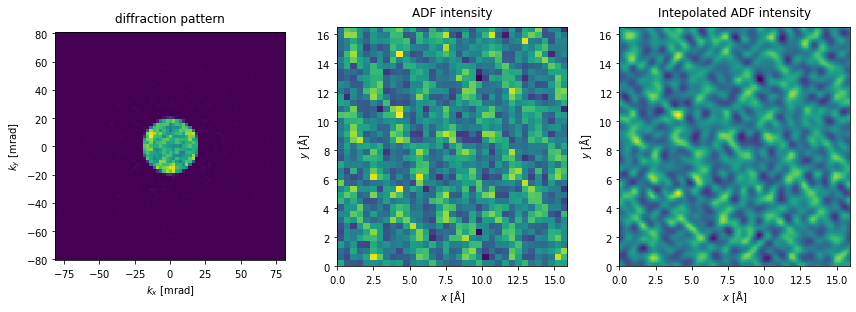

In [5]:
tiled_measurements = diffraction_patterns.tile_scan((5, 3)).poisson_noise(1e5)
cropped_measurements = tiled_measurements.crop(max_angle=81)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,5))
cropped_measurements.show(ax=ax1, title="diffraction pattern", units="mrad")
tiled_measurements.integrate_radial(50, 150).show(
    ax=ax2, title="ADF intensity"
)
tiled_measurements.integrate_radial(50, 150).interpolate(.1).show(
    ax=ax3, title="Intepolated ADF intensity"
)

plt.tight_layout()

To run PIE we create a `RegularizedPtychographicOperator` and initialize it with `DiffractionPatterns`. The necessary experimental parameters are:

* `energy`: Acceleration voltage in keV.
* `semiangle_cutoff`: Convergence semiangle in mrad of the initial probe guess.
* `scan_step_sizes`: The sampling rate of the probe in Ångstrom.
* `angular_sampling`: The reciprocal space sampling of the diffraction patterns in mrad.

We can also pass a `Probe` object to specify an initial probe guess with aberrations, however, one of the strengths of r-PIE is reconstructing the probe aberrations, so we typically omit this.

Additionally, the following optional experimental parameters are available:

* `rotation_angle`: The rotation angle between the scan directions and the . Unless deliberately introduced this is zero in simulations.
* `background_counts_cutoff`: The diffraction intensities (or electron counts) below this value are set to zero.
* `counts_scaling_factor`: The diffraction intensities are divided by this factor.
* `object_px_padding`: By default the reconstructed object in real space is padded to avoid the effect periodicity to influence the reconstruction. In the special case, such as our simulation, of a perfectly periodic scan region this can be set to zero.

If you're passing a `DiffractionPatterns` object, most of these will be automatically detected. Here we specify `object_px_padding:(0,0)` to indicate we're interested in a periodic reconstruction.

```{seealso}
See our experimental rPIE example to understand how to set these parameters given an experimental dataset.
```

In [6]:
ptycho_operator = RegularizedPtychographicOperator(
    cropped_measurements,
    parameters={"object_px_padding": (0, 0)},
)

ptycho_operator.preprocess()

The reconstruction algorithm has a lot of hyper-parameters (such as update step sizes and regularization), the main ones are:

* `alpha`: Controls the weights of the object update function, small values of $alpha$ increases the weights of less illuminated object pixels. Lowering $\alpha$ can help increase the convergence rate, however, this may come at the cost of less stability. Default is 1.0.
* `beta`: The equivalent of $\alpha$ for the probe update function.
* `object_step_size`: The (initial) step size for the object update function, given as $\gamma_{\mathrm{obj}}$ in {cite}`maiden_pie`. Increasing this may improve convergence rate at the cost of stability. Default is 1.0.
* `probe_step_size`: The equivalent of $\gamma_{\mathrm{obj}}$ for the probe update function.
* `step_size_damping_rate`: The damping rate of the step sizes. Default is 0.995.

The default hyperparameters values perform reasonably well, however, since we can conservatively set $\alpha = 0.5$ to improve the speed of convergence.

We set `max_iterations=5`, thus each probe position is used 5 times. We set `return_iterations=True` to return the object and probe after each iteration. We set `verbose=True` to print the steps the algorithm will take, and the error at each iteration.

In [7]:
rpie_objects, rpie_probes, rpie_positions, rpie_sse = ptycho_operator.reconstruct(
    max_iterations=5, return_iterations=True, random_seed=1, verbose=True
)

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 6825 steps
--Probe correction is enabled
----Iteration 0, SSE = 7.228e-04
----Iteration 1, SSE = 6.253e-06
----Iteration 2, SSE = 5.935e-06
----Iteration 3, SSE = 5.533e-06
----Iteration 4, SSE = 5.489e-06


Comparing the output from ptychography to ADF, we see two distinct advantages: 

* We see that the rPIE algorithm succesfully deconvolved the effect of the probe from the potential after just a few iterations.  
* Improved resolution, we scanned at the nyquist sampling with probe with a convergence semiangle of $20 \ \mathrm{mrad}$, however we obtained reconstruction with a reciprocal space sampling matching the detector, which has a significantly higher maximum angle than the probe. 

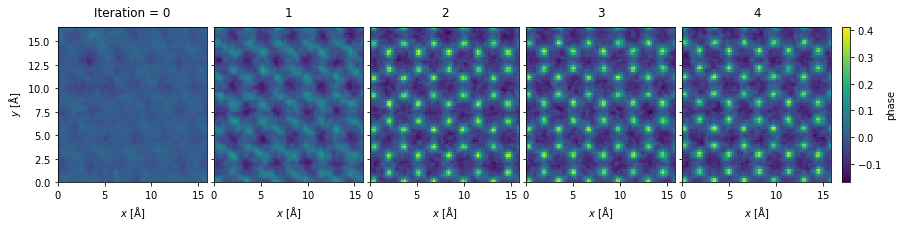

In [8]:
rpie_objects.phase().show(
    explode=True, figsize=(14, 5), cbar=True, common_color_scale=True
);

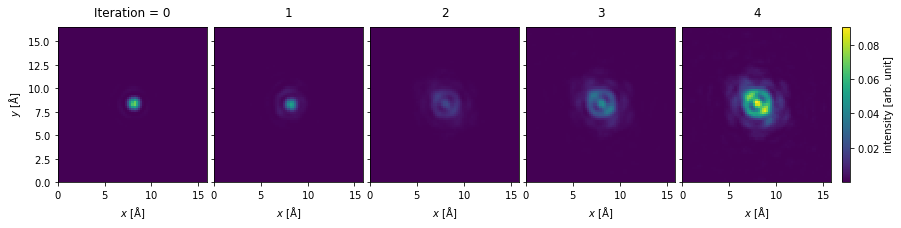

In [9]:
rpie_probes.intensity().show(
    explode=True, figsize=(14, 5), cbar=True, common_color_scale=True, #vmax=1.8e-6
);